In [82]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os, PIL, re
from scipy.spatial import distance
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
from tslearn.preprocessing import TimeSeriesResampler


#### Read pictures

In [38]:
def cutLabel(string):
    re = ''
    for c in string:
        if c not in ['0','1','2','3','4','5','6','7','8','9','_']:
            re = re + c
    return re

In [83]:
directory ='pact_pala_samples/'


X=[]
Y=[]

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        img = cv.imread(directory+filename,0)
        edges = cv.Canny(img,0,100)
        label = re.sub(r'\.[^.]*$',"",filename) #removing file extension
        label = cutLabel(label) #removing numbers because Im bad at regex
        
        center = [x//2 for x in edges.shape]
        leaf_shape_arr = np.array(np.where (edges == 255)) #2d array containing position of white dots
        leaf_series = []
        for i in range(0,(leaf_shape_arr.shape[1])): #for each white dot
            dst = distance.euclidean(center, leaf_shape_arr[:,i]) #measure the Euclidean distance from the center to that dot
            leaf_series.append(dst) #add them to a list to make a series, this is also the series of the leaf shape
        leaf_series = np.array(leaf_series)
        
        leaf_series_resized = TimeSeriesResampler(sz=500).fit_transform(leaf_series) # resize series so that they all have the same size to plug to CNN, etc.
        leaf_series_resized = leaf_series_resized[0]
        
        X.append(leaf_series_resized)
        Y.append(label)
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(188, 500, 1)
(188,)


### Binary encoding and shuffle

In [84]:
binLabel = lambda l: 0 if l=='Pact' else 1
vfunc = np.vectorize(binLabel) 
Y = vfunc(Y)

In [85]:
X, Y = shuffle(X, Y, random_state=0) #also keeping X,Y order unchanged

In [86]:
X_train = X[:120]
Y_train = Y[:120]
X_test  = X[120:]
Y_test  = Y[120:]

In [103]:
Y_test

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1])

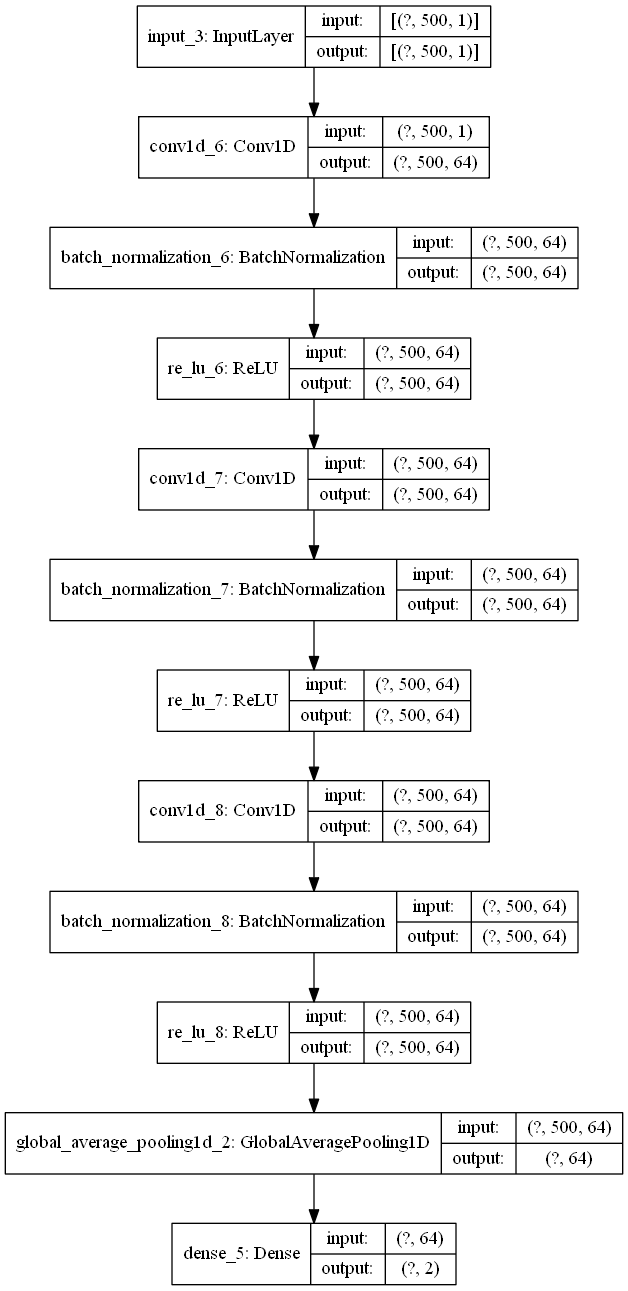

In [101]:
num_classes = len(set(Y))
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [104]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 200ms/step - loss: 0.5858 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.8344 - val_sparse_categorical_accuracy: 0.2917
Epoch 2/500
3/3 [==============================] - 0s 151ms/step - loss: 0.3225 - sparse_categorical_accuracy: 0.8854 - val_loss: 1.6426 - val_sparse_categorical_accuracy: 0.2917
Epoch 3/500
3/3 [==============================] - 0s 118ms/step - loss: 0.3137 - sparse_categorical_accuracy: 0.8854 - val_loss: 1.1095 - val_sparse_categorical_accuracy: 0.2917
Epoch 4/500
3/3 [==============================] - 0s 129ms/step - loss: 0.2914 - sparse_categorical_accuracy: 0.8750 - val_loss: 1.0143 - val_sparse_categorical_accuracy: 0.2917
Epoch 5/500
3/3 [==============================] - 1s 215ms/step - loss: 0.3538 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.9420 - val_sparse_categorical_accuracy: 0.2917
Epoch 6/500
3/3 [==============================] - 0s 130ms/step - loss: 0.3698 - sparse_categorical_accu

In [108]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

3/3 [==============================] - 0s 12ms/step - loss: 0.4357 - sparse_categorical_accuracy: 0.8235
Test accuracy 0.8235294222831726
Test loss 0.43569332361221313
